# predictive Analysis on commercial success of games

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score


In [2]:
df = pd.read_csv('xceldata.csv', encoding="utf-8")


## Defining hits as those with sales above 1 million units

In [3]:
df = df.dropna(axis=0)


In [4]:
dfb = df[['Name','ESRB_Rating','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sale']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['ESRB_Rating','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sale']]
df2['Hit'] = df2['Global_Sale']
df2.drop('Global_Sale', axis=1, inplace=True)

In [5]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

## Generating features

In [6]:


df3=df2['Genre'].str.get_dummies(sep = ',')
df4=pd.concat([df2,df3], axis=1)
df4.drop('Genre', axis=1, inplace=True)
df5 = pd.get_dummies(df4)
df5.columns

Index(['Year_of_Release', 'Critic_Score', 'Hit', 'A1', 'Action', 'Adventure',
       'Arcade', 'Card Game', 'Compilation', 'Fighting',
       ...
       'Publisher_Yacht Club Games',
       'Publisher_YooStar Entertainment Group Inc.', 'Publisher_Yukes',
       'Publisher_Zoo Digital Publishing', 'Publisher_Zoo Games',
       'Publisher_Zushi Games', 'Publisher_bitComposer Games',
       'Publisher_id Software', 'Publisher_inXile Entertainment',
       'Publisher_tinyBuild'],
      dtype='object', length=388)

## Split Data & Traning

In [7]:

y = df5['Hit'].values
df5 = df5.drop(['Hit'],axis=1)
X = df5.values

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=2)


## Testing prediction accuracy with LR and RFC

In [9]:
log_reg = LogisticRegression(max_iter=3000).fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Logistic Regression Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values==ytest)/len(ytest))

Logistic Regression Validation accuracy:  0.8456744868035191


In [10]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2280
           1       0.60      0.18      0.28       448

    accuracy                           0.85      2728
   macro avg       0.73      0.58      0.59      2728
weighted avg       0.82      0.85      0.81      2728



Text(0.5, 1.0, ' LR')

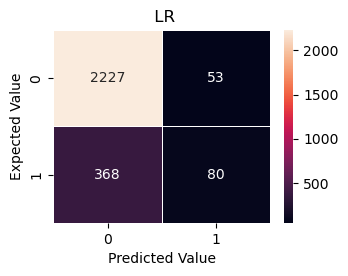

In [11]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
plt.title(' LR')

AUC: 0.8142250156641604


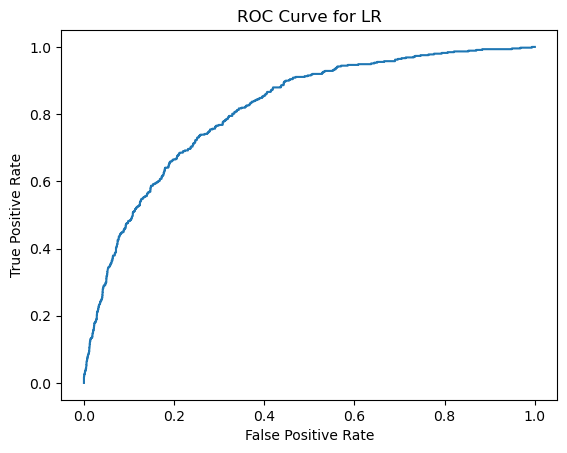

In [12]:


y_prob = y_val_2[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ytest, y_prob)
auc_score = roc_auc_score(ytest, y_prob)
print('AUC:', auc_score)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LR')
plt.show()

In [13]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Random Forest Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Random Forest Validation accuracy:  0.8357771260997068


In [14]:
all_predictRadm = radm.predict(Xtest)
print(classification_report(ytest, all_predictRadm))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2280
           1       0.50      0.38      0.43       448

    accuracy                           0.84      2728
   macro avg       0.69      0.65      0.67      2728
weighted avg       0.82      0.84      0.83      2728



Text(0.5, 1.0, 'RFC')

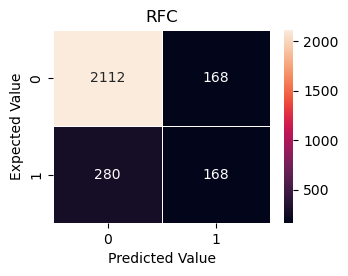

In [15]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictRadm), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
plt.title('RFC')

AUC: 0.8154884281015037


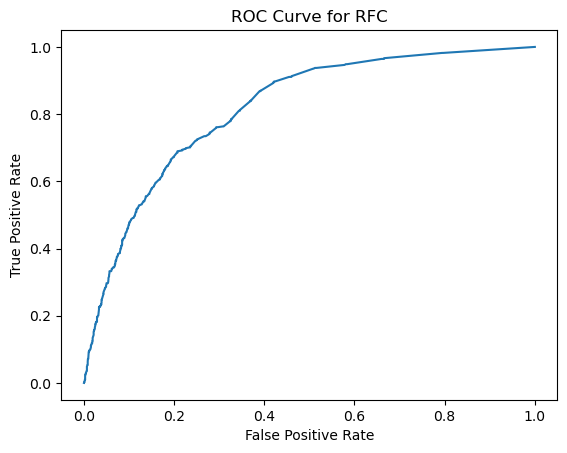

In [16]:


y_prob2 = y_val_1[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ytest, y_prob2)
auc_score = roc_auc_score(ytest, y_prob2)
print('AUC:', auc_score)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RFC')
plt.show()

In [17]:
new_data = pd.read_csv('test.csv', encoding="utf-8")
new_data

,Name,Year_of_Release,Genre,Publisher,Critic_Score,ESRB_Rating,Global_Sale
0,King4,2023,Fighting,Snk,98,T,NaN


In [18]:
# Preprocess the new data
new_data = new_data[['ESRB_Rating','Genre','Publisher','Year_of_Release','Critic_Score']]
new= new_data['Genre'].str.get_dummies(sep = ',')
new_data = pd.concat([new_data,new], axis=1)
new_data.drop('Genre', axis=1, inplace=True)
new_data = pd.get_dummies(new_data)




In [19]:
# Ensure that the preprocessed new data has the same column order as the preprocessed training data
new_data = new_data.reindex(columns=df5.columns, fill_value=0)

In [20]:
# Use the trained model to make predictions on the new data
y_pred = radm.predict_proba(new_data.values)
y_pred

array([[0.40666667, 0.59333333]])

In [21]:
# Use the trained model to make predictions on the new data
y_pred = log_reg.predict_proba(new_data.values)
y_pred

array([[0.43777209, 0.56222791]])

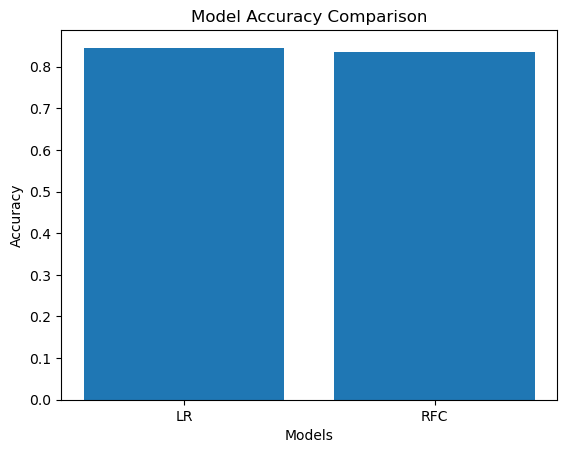

In [26]:
models = ['LR', 'RFC']
accuracy = [0.8456744868035191, 0.8357771260997068]

# Create the graph
plt.bar(models, accuracy)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

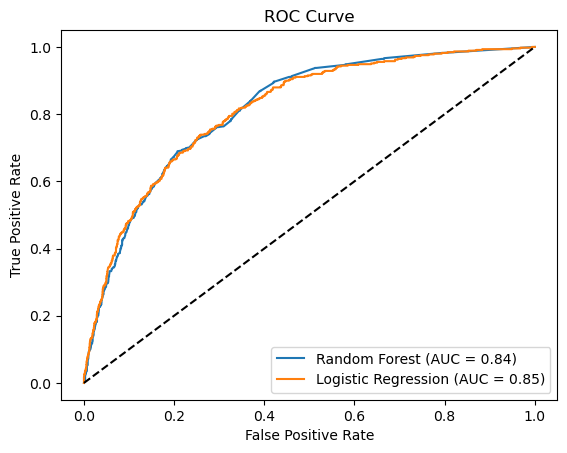

In [29]:
y_prob_1 =  y_val_1[:, 1]
y_prob_2 = y_val_2[:, 1]

# Calculate the FPR, TPR, and thresholds for the two models
fpr_1, tpr_1, thresholds_1 = roc_curve(ytest, y_prob_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(ytest, y_prob_2)

# Calculate the AUC scores for the two models
auc_1 = 0.8357771260997068
auc_2 = 0.8456744868035191

# Create a ROC curve for each model
fig, ax = plt.subplots()
ax.plot(fpr_1, tpr_1, label='Random Forest (AUC = {:.2f})'.format(auc_1))
ax.plot(fpr_2, tpr_2, label='Logistic Regression (AUC = {:.2f})'.format(auc_2))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
plt.show()

In [30]:
from sklearn.metrics import log_loss

# Logistic Regression
y_val_2_proba = log_reg.predict_proba(Xtest)
lr_loss = log_loss(ytest, y_val_2)
print("Logistic Regression Loss: ", lr_loss)

# Random Forest Classifier
y_val_1_proba = radm.predict_proba(Xtest)
rfc_loss = log_loss(ytest, y_val_1)
print("Random Forest Classifier Loss: ", rfc_loss)

Logistic Regression Loss:  0.3543334398426007
Random Forest Classifier Loss:  0.47632458600953925
